In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast

from sys import path
path.insert(0, "lib")
from lib.onedmodel import *
from lib.SGD_utils import *
from pathlib import Path


In [2]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

In [3]:
def generate_many_traj(sgd_runner, model, w_inits, auto=True, seed=1) -> DataFrame:
        # Set up seed for reproducibility
        torch.manual_seed(seed)
        data = {'w_init': [], 'trajectory': [], 'loss': []}
        for i in range(sgd_runner.nSGD):
            if i % 1000 == 0:
                print(f"trajectory {i} over {sgd_runner.nSGD}")
            wi = torch.tensor(w_inits[i])
            model.update_params(w_init=wi) # change feature 
            model.update_params(weight=torch.nn.Parameter(model.w_init)) #re-initialise before training
            if auto==True:
                running_loss, running_weight = sgd_runner.train_with_autograd(model, w_init=model.w_init)
            else:  
                running_loss, running_weight = sgd_runner.train_with_mangrad(model, w_init=model.w_init)
            data['w_init'].append(model.w_init.item())
            data['trajectory'].append(running_weight)
            data['loss'].append(running_loss)

        # Construct the filename
        df = pd.DataFrame(data)
        return df

def clean_trajectories(df):
    """
    Filter exploding trajectories and convert strings into array of trajectories
    """
    trajectories = np.asarray(df['trajectory'].to_list())
    clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
    return clean_traj

In [4]:
np.random.seed(seed=1)
model = PolyModel()
sgd_runner = SGDPolyRunner(nSGD=2, batch_size=30, lr=0.01, niter=2)
wm = 2 * model.w0
w_inits = [0.1, 0.1]
df_man = generate_many_traj(sgd_runner, model, w_inits, auto=False)


trajectory 0 over 2


In [5]:
np.random.seed(seed=1)
model = PolyModel()
sgd_runner = SGDPolyRunner(nSGD=2, batch_size=30, lr=0.01, niter=2)
wm = 2 * model.w0
w_inits = [0.1, 0.1]
df_auto = generate_many_traj(sgd_runner, model, w_inits, auto=True)

trajectory 0 over 2


In [6]:
print(w_inits)

[0.1, 0.1]


In [7]:
print(w_inits)
print(df_man['w_init'])
print(df_auto['w_init'])

[0.1, 0.1]
0    0.1
1    0.1
Name: w_init, dtype: float64
0    1.336883
1    1.265344
Name: w_init, dtype: float64


In [7]:
df_auto = generate_auto_traj(sgd_runner, model, w_inits)

trajectory 0 over 10000
trajectory 1000 over 10000
trajectory 2000 over 10000
trajectory 3000 over 10000
trajectory 4000 over 10000
trajectory 5000 over 10000
trajectory 6000 over 10000
trajectory 7000 over 10000
trajectory 8000 over 10000
trajectory 9000 over 10000


In [8]:
print(w_inits)
print(df_auto['w_init'])

[-0.37588238 -1.45044872  1.43805433 ... -0.89140591 -1.66873217
  0.0708237 ]
0       1.911711
1       1.908239
2       1.896180
3       1.893972
4       1.907610
          ...   
9995    1.910948
9996         NaN
9997         NaN
9998    1.907296
9999    1.921431
Name: w_init, Length: 10000, dtype: float64


In [7]:
man_traj = df_man["trajectory"].to_list()
auto_traj = df_auto["trajectory"].to_list()

In [8]:
print(df_auto['w_init'])
print(df_man['w_init'])


0       1.912292
1            NaN
2       1.894883
3       1.895131
4       1.907838
          ...   
9995         NaN
9996    1.918564
9997    1.862780
9998    1.909173
9999    1.922106
Name: w_init, Length: 10000, dtype: float64
0       0.552422
1      -2.829702
2      -0.056320
3      -0.409747
4       0.694389
          ...   
9995   -3.019205
9996   -1.835390
9997    0.564633
9998    3.250425
9999    1.077142
Name: w_init, Length: 10000, dtype: float64


(0.001, 1)

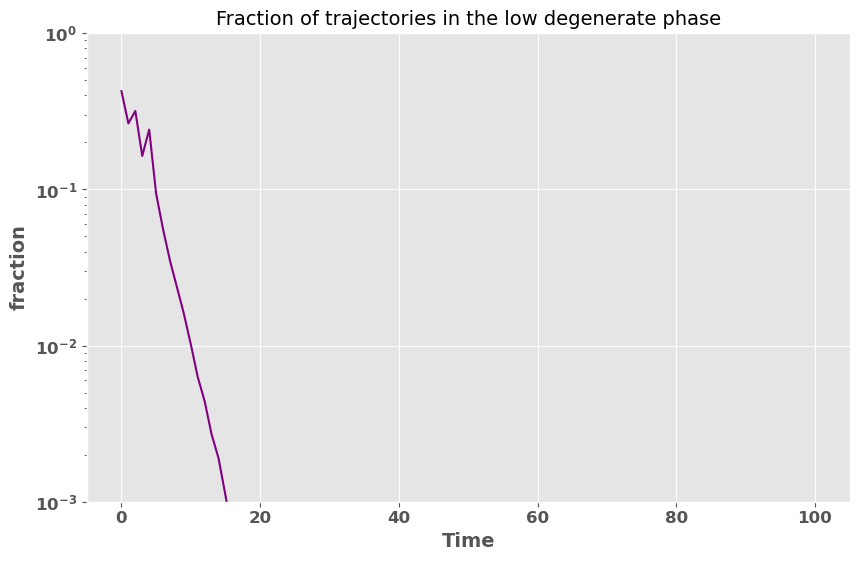

In [9]:
# Plot rate of escape
%matplotlib inline
# Plot phase change
wmax = (model.w0*model.d1 - model.w0*model.d2)/(model.d1 + model.d2)
trajectories = df_man['trajectory'].to_list()
trajectories = np.asarray(trajectories)
end_traj = trajectories[:,-1]
phases = np.zeros_like(trajectories)
phases[trajectories - wmax > 0] = 1
phases[trajectories - wmax < 0] = -1

fraction_regular_phase = np.sum(phases == -1,axis=0)/phases.shape[0]
fraction_singular_phase = np.sum(phases == 1,axis=0)/phases.shape[0]

nit = len(fraction_regular_phase)
time = np.arange(0, nit,1)

plt.plot(time, fraction_regular_phase[time], color="purple")
#plt.plot(time, fraction_singular_phase[time], label = "low RLCT", color="orange")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.title("Fraction of trajectories in the low degenerate phase")
plt.ylim((0.001,1))

(0.001, 1)

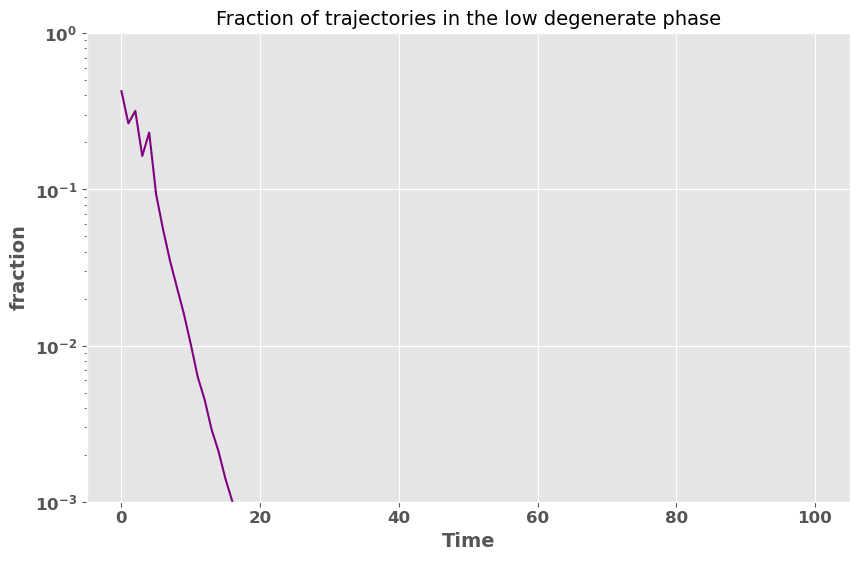

In [10]:
# Plot rate of escape
%matplotlib inline
# Plot phase change
wmax = (model.w0*model.d1 - model.w0*model.d2)/(model.d1 + model.d2)
trajectories = df_auto['trajectory'].to_list()
trajectories = np.asarray(trajectories)
end_traj = trajectories[:,-1]
phases = np.zeros_like(trajectories)
phases[trajectories - wmax > 0] = 1
phases[trajectories - wmax < 0] = -1

fraction_regular_phase = np.sum(phases == -1,axis=0)/phases.shape[0]
fraction_singular_phase = np.sum(phases == 1,axis=0)/phases.shape[0]

nit = len(fraction_regular_phase)
time = np.arange(0, nit,1)

plt.plot(time, fraction_regular_phase[time], color="purple")
#plt.plot(time, fraction_singular_phase[time], label = "low RLCT", color="orange")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.title("Fraction of trajectories in the low degenerate phase")
plt.ylim((0.001,1))

In [17]:
man_traj = clean_trajectories(df_man)
auto_traj = clean_trajectories(df_auto)

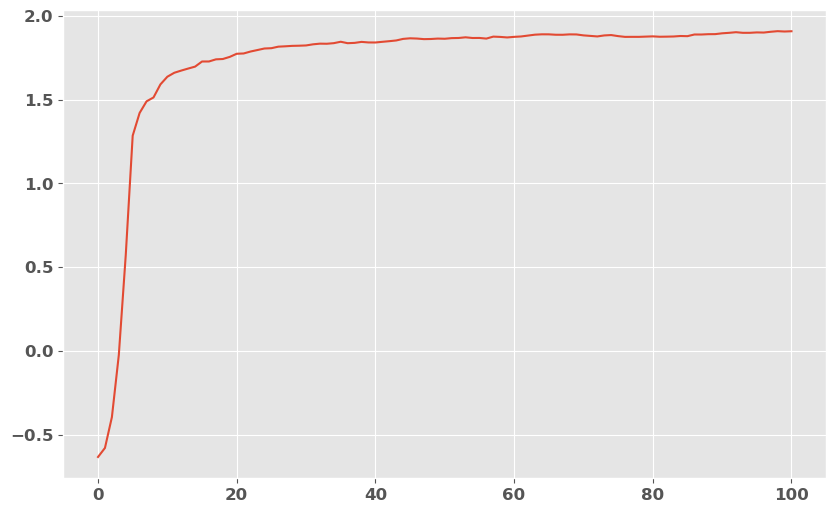

In [20]:
ntraj = len(man_traj)
itraj = np.random.randint(0,ntraj)
plt.plot(time, man_traj[itraj])

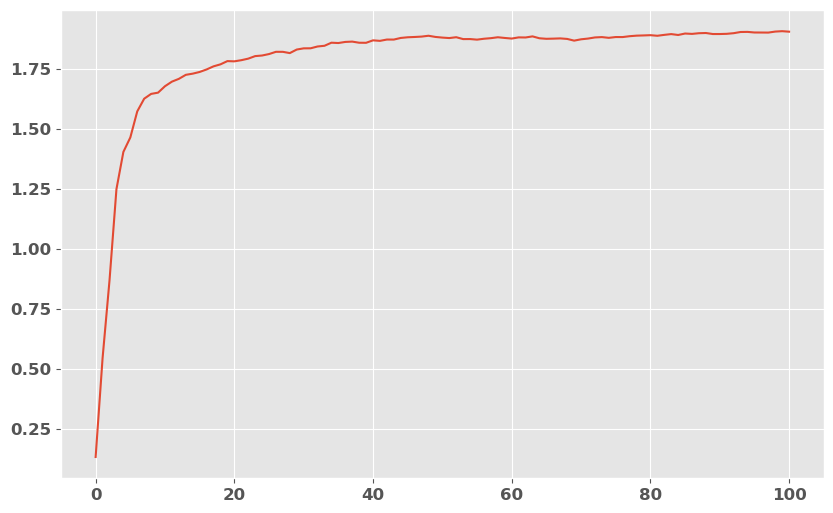

In [19]:
plt.plot(time, auto_traj[itraj])

In [ ]:
# Compare gradients

